In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
from scipy import stats
from scipy.spatial import distance_matrix
import scikit_posthocs

from Bio import SeqIO
from glob import glob
import os
import re

In [2]:
colors = ['#1b9e77','#d95f02','#7570b3','#a6761d','#e7298a','#e6ab02','#666666','#66a61e']

# metagenome stats summary

## Load and merge tables

In [3]:
# read summary table and contamination table
summary_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/tables/summary_stats_table_060623.csv') # downloaded from manually compiled google sheet
metag_contam_info = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/tables/all_contam_report_060623.txt', sep='\t') # based on concatenated contamination reports from find_contams.py
metag_contam_info = metag_contam_info[metag_contam_info.sample_name != 'sample_name']

# read flow cytometry data table
fcm = pd.read_csv('/Users/rosekantor/data/awtp2/amplicon_16S/fcm_data_geomean.tsv', sep='\t')
fcm.loc[fcm.location_code == 'influent', 'location_code'] = 'WW_3ary'
fcm['sample_id'] = fcm.location_code + "_" + fcm.day.astype('str')

# merge summary, contam, and fcm into one df and set categories for plotting
summary_df = summary_df.merge(metag_contam_info, how='outer', on='sample_name')
summary_df = summary_df.merge(fcm, how='left', on='sample_id')

# filter out samples that were not included in metagenomics, adjust types, add categories for plotting
summary_metag_df = summary_df[~summary_df.assembly_size_mbp.isna()].copy()
summary_metag_df.perc_cov = summary_metag_df.perc_cov.astype('float')
summary_metag_df.total_length = summary_metag_df.total_length.astype('float')
summary_metag_df.Location = pd.Categorical(summary_metag_df.Location, ordered=True, categories=('WW_3ary', 'BAC', 'MF_combined', 
                                                                                    'RO_BF_retentate_scrapings', 'RO_BF_separator',
                                                                                                'RO_2stage'))

# create column showing assembly size in Mbp (including contigs >1kb)
summary_metag_df['assembly_size_1kb_mbp'] = summary_metag_df.total_length / 1000000

## plot contamination vs yield

In [4]:
location_colors=['#A50026','#FDBE70','#BCE1EE',"#A9A9A9","#D3D3D3",'#313695']

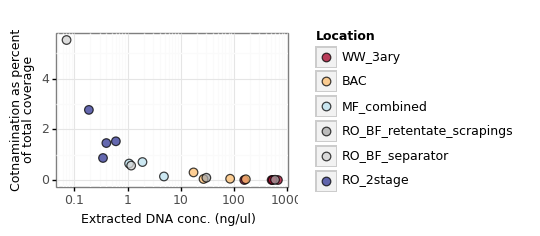

<ggplot: (359585714)>

In [5]:
# explore %contamination vs DNA extraction yield
plt = (ggplot(summary_metag_df, aes(x='DNA_ng_per_ul', y='perc_cov', fill='Location'))+
geom_point(size=3, color='black', alpha=0.75)+
scale_fill_manual(values=location_colors)+
scale_x_log10()+
xlab('Extracted DNA conc. (ng/ul)')+
ylab('Cotnamination as percent\nof total coverage')+
theme_bw()+
theme(figure_size=(3,2),
      axis_text_x=element_text(size=9),
      axis_text_y=element_text(size=9),
      axis_title=element_text(size=9),
      legend_text=element_text(size=9),
      legend_title=element_text(size=9, weight='bold')))
display(plt)
#ggsave(plt, '/Users/rosekantor/data/awtp2/metagenomics/figures/dna_vs_contam.svg')
#ggsave(plt, '/Users/rosekantor/data/awtp2/metagenomics/figures/dna_vs_contam.png')

# All Membrane dRep MAGs abundances across samples

## Calculate % reads mapped to bins in each sample, not including contaminated reads

In [16]:
# equations for % reads mapped:
# without contam: % mapped = 100 * (sum of bin cov) / (total sample cov)
# or could do % mapped = 100 * (mapped to bins Gbp) / (total sample Gbp)
# or could do % mapped = 100 * (reads mapped to bins) / (total sample reads)
# to account for contam, % mapped = 100 * (mapped to bins Gbp) / ((total sample Gbp) * (100 - percent contam))
# this is the same as multiplying by the contam_inflation_factor

# to create the table imported here, the following was run and then pasted together with total readcounts in google sheet
# for i in dRep_membranes-vs-AWTP2_SAMPLE_*.bam; do samtools view -c -F 260 $i >> mapped_read_counts.txt; done

read_mapping_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/tables/counts_read_mapping_dRep_mags.tsv', sep='\t')
read_mapping_df['sample_id'] = read_mapping_df['sample_id'].str.replace('-', '_')

# add perc_cov that was suspected contaminant
read_mapping_df = read_mapping_df.merge(metag_contam_info[['sample_name', 'perc_cov']], left_on='sample_id', right_on='sample_name', how='outer')
read_mapping_df = read_mapping_df.drop(columns=['sample_name'])
read_mapping_df.perc_cov = read_mapping_df.perc_cov.astype('float')
read_mapping_df = read_mapping_df.rename(columns={'perc_cov':'perc_contam_cov'})
read_mapping_df['perc_mapped'] = 100 * read_mapping_df.reads_mapped_to_dRep_mags / read_mapping_df.total_trimmed_reads
read_mapping_df['perc_mapped'] = read_mapping_df['perc_mapped'] * 100/(100 - read_mapping_df.perc_contam_cov)
read_mapping_df
#read_mapping_df.to_csv('/Users/rosekantor/data/awtp2/metagenomics/tables/counts_perc_read_mapping_dRep_mags.tsv')
# read_mapping_df.to_clipboard(index=False)

,sample_id,num_seqs_fw_tr,total_trimmed_reads,reads_mapped_to_dRep_mags,perc_contam_cov,perc_mapped
0,AWTP2_SAMPLE_BAC_BULK_2,99005162,198010324,2593862,0.30,1.313905
1,AWTP2_SAMPLE_BAC_BULK_3,79963723,159927446,1281873,0.04,0.801855
2,AWTP2_SAMPLE_BAC_BULK_4,101909303,203818606,5519999,0.05,2.709645
3,AWTP2_SAMPLE_BAC_BULK_5,97338134,194676268,3627090,0.03,1.863698
4,AWTP2_SAMPLE_INF_BULK_2,99621275,199242550,88111,0.00,0.044223
5,AWTP2_SAMPLE_INF_BULK_3,96408879,192817758,85191,0.00,0.044182
6,AWTP2_SAMPLE_INF_BULK_4,92637317,185274634,105047,0.00,0.056698
7,AWTP2_SAMPLE_INF_BULK_5,53132383,106264766,244777,0.00,0.230346
8,AWTP2_SAMPLE_MFCOMB_BULK_1,24189805,48379610,29079635,0.65,60.500466
9,AWTP2_SAMPLE_MFCOMB_BULK_2,25281594,50563188,22006945,0.71,43.834878


## Get MAG x Sample coverage table with iRep

### Combine MAG info from checkM, GTDB, anvio summary, and manual renaming

In [913]:
# read tables
checkm_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/genomeInfo.csv')
tax_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/gtdbtk.bac120.summary.tsv', sep='\t')
bins_renamed_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_info.tsv', sep='\t')
anvio_sum_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/bins_summary.txt', sep='\t')

# select and make columns from each table
checkm_df.genome = checkm_df.genome.str.extract(r'(.*).fa') # genome name ends in .fa, remove before merge
checkm_df = checkm_df[['genome', 'completeness', 'contamination', 'strain_heterogeneity']]

tax_df = tax_df[['user_genome', 'classification']]
tax_df['short_taxonomy'] = tax_df.classification.str.extract(r';(c_.*);s_.*')
tax_df['phylum'] = tax_df.classification.str.extract(r';p__(.*);c__.*')
tax_df['full_taxonomy'] = tax_df['short_taxonomy'].str.replace('__','_')

bins_renamed_df = bins_renamed_df[['user_genome', 'sensible_name']]
bins_renamed_df = bins_renamed_df.rename(columns={'sensible_name':'MAG_name'})

# merge tables
mag_stats_df = tax_df.merge(checkm_df, how='left', left_on='user_genome', right_on='genome')
# merge in the manual renamed bins
mag_stats_df = mag_stats_df.merge(bins_renamed_df, on='user_genome', how='left')

# change bin names to match those in the anvio table
mag_stats_df['genome'] = mag_stats_df['genome'].str.replace('.', '_', regex=False)
mag_stats_df['genome'] = mag_stats_df['genome'].str.replace('-', '_', regex=False)

mag_stats_df = mag_stats_df.merge(anvio_sum_df, how='outer', left_on='genome', right_on='bins')
mag_stats_df['length_mbp'] = mag_stats_df.total_length/1e6

# select final columns
mag_stats_df = mag_stats_df[['MAG_name','bins','phylum','full_taxonomy',
        'completeness', 'contamination','length_mbp', 'num_contigs', 'GC_content']]

In [914]:
mag_stats_df.head()

,MAG_name,bins,phylum,full_taxonomy,completeness,contamination,length_mbp,num_contigs,GC_content
0,o__Oligoflexales,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_15,Bdellovibrionota,c_Oligoflexia;o_Oligoflexales;f_RGVZ01;g_CAMDKS01,83.33,0.89,4.273712,552,45.612409
1,o__Rickettsiales_2,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_40_sub,Pseudomonadota,c_Alphaproteobacteria;o_Rickettsiales;f_UBA300...,81.09,1.26,1.840193,481,58.255258
2,f__Bdellovibrionaceae,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_58,Bdellovibrionota,c_Bdellovibrionia;o_Bdellovibrionales;f_Bdello...,98.21,0.89,2.933415,39,38.525602
3,p__Bdellovibrionota_2,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_61,Bdellovibrionota,c_UBA1018;o_UBA1018;f_UBA1018;g_JAEUWC01,91.96,0.89,3.663908,20,52.481168
4,s__Sphingopyxis_terrae,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_71,Pseudomonadota,c_Alphaproteobacteria;o_Sphingomonadales;f_Sph...,81.66,5.13,2.848604,1197,65.493528


### Calculate normalized coverage for each bin in each sample

In [915]:
# import coverage and mask on detection > 0.10 (genome breadth of coverage over 10% of length)
# require ≥ 1x avg coverage across the covered region (by creating a mask for the df)

anvio_cov_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/bins_across_samples/mean_coverage_Q2Q3.txt', 
                           sep='\t', index_col=0)

anvio_detect_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/bins_across_samples/detection.txt',
                              sep='\t', index_col=0)

anvio_cov_df = anvio_cov_df[(anvio_cov_df/anvio_detect_df)>=1]

mask = anvio_detect_df > 0.10

anvio_cov_df = anvio_cov_df[mask]

anvio_cov_df = anvio_cov_df.reset_index()
anvio_cov_df = anvio_cov_df.melt(id_vars='bins', var_name='sample_name', value_name='coverage')

In [916]:
# merge with contamination info and general info to get total seq and perc cov of contams
contam_seq_df = summary_df[~summary_df.sample_name.isna()][['sample_name','sample_id','total_seq_Gb', 'perc_cov']].copy()
contam_seq_df = contam_seq_df.rename(columns={'perc_cov':'perc_contam_cov'})
anvio_cov_df = anvio_cov_df.merge(contam_seq_df, how='left', on='sample_name')

In [917]:
# calculate median normalized coverage 
# norm_cov = (median(total seq) * MAG cov / total seq)

anvio_cov_df.perc_contam_cov = pd.to_numeric(anvio_cov_df.perc_contam_cov)
anvio_cov_df['contam_inflation_factor'] = 100 / (100 - anvio_cov_df.perc_contam_cov)
anvio_cov_df['normalized_cov'] = np.median(anvio_cov_df.total_seq_Gb) * \
                                 (anvio_cov_df.coverage / anvio_cov_df.total_seq_Gb) * \
                                 anvio_cov_df.contam_inflation_factor

In [918]:
# drop samples from second RO autopsy samples which were used for binning but excluded from main text
anvio_cov_df = anvio_cov_df[~anvio_cov_df.sample_id.isin(['RO_BF_retentate_scrapings_328','RO_BF_separator_328'])]

### Add iRep results (via inStrain)

In [919]:
instrain_df = []
for file in glob('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/instrain/*genome_info.tsv'):
    sample_id = os.path.basename(file)
    sample_id = re.split("_genome_info", sample_id)[0]
    df = pd.read_csv(file, sep='\t')
    df['sample_name'] = sample_id
    instrain_df.append(df)
        
instrain_df = pd.concat(instrain_df)
instrain_df = instrain_df.rename(columns={'genome':'bins'})

# calculate scaffolds per mbp so we can filter on it
instrain_df['scaffolds_per_mbp'] = instrain_df['true_scaffolds'] * 1e6 / instrain_df['length']

In [920]:
# only trust iRep values where conditions are met:

# get list of genomes with completeness > 75 and contam < 5
clean_bins = mag_stats_df[(mag_stats_df.completeness > 75) & (mag_stats_df.contamination < 5)]['bins'].to_list()

# iRep filters
instrain_iRepFilt_df = instrain_df[(instrain_df.coverage >= 5) &
                                   (instrain_df.scaffolds_per_mbp <= 175) &
                                   (instrain_df.bins.isin(clean_bins)) &
                                   (instrain_df.breadth > 0.90) &
                                   (~instrain_df.iRep.isna())].copy()

irep_keep = instrain_iRepFilt_df[['bins', 'sample_name', 'iRep']].copy()

In [921]:
# add irep to anvio and pivot
final_mag_df = anvio_cov_df.merge(irep_keep, on=['sample_name', 'bins'], how='left', suffixes=('_anv', '_ins'))
final_mag_df = final_mag_df.sort_values('sample_id') # sort by sample_id so that pivoting produces ordered columns 
final_mag_df_wide = final_mag_df.pivot(columns = 'sample_id', index= 'bins', values = ['normalized_cov','iRep']).reset_index()

# add stats on mags
final_mag_df_wide = pd.merge(mag_stats_df,final_mag_df_wide, on='bins', how='right')

#final_mag_df_wide.to_csv('/Users/rosekantor/data/awtp2/metagenomics/tables/dRep_MAGs_final_table.tsv', sep='\t', index=False)

# exported for Table S2

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


## Rank abundances with iRep

In [922]:
# get dfs of just RO or just MF and set order for plotting
rank_ab_df = final_mag_df.merge(mag_stats_df[['bins', 'MAG_name']], on='bins', how='right')
rank_ab_df = rank_ab_df[['MAG_name', 'sample_id', 'normalized_cov', 'iRep']]

# for RO
rank_ab_RO_df = rank_ab_df[(rank_ab_df.sample_id.str.contains('RO_2stage')) &
                           (~rank_ab_df.normalized_cov.isna())].copy()
ro_plot_order = rank_ab_RO_df[['MAG_name', 'normalized_cov']].groupby('MAG_name').mean().reset_index()
ro_plot_order = ro_plot_order.sort_values('normalized_cov', ascending=False).MAG_name.to_list()
rank_ab_RO_df.MAG_name = pd.Categorical(rank_ab_RO_df.MAG_name, ordered=True, categories = ro_plot_order)

# for MF
rank_ab_MF_df = rank_ab_df[(rank_ab_df.sample_id.str.contains('MF_combined')) &
                           (~rank_ab_df.normalized_cov.isna())].copy()
mf_plot_order = rank_ab_MF_df[['MAG_name', 'normalized_cov']].groupby('MAG_name').mean().reset_index()
mf_plot_order = mf_plot_order.sort_values('normalized_cov', ascending=False).MAG_name.to_list()

rank_ab_MF_df.MAG_name = pd.Categorical(rank_ab_MF_df.MAG_name, ordered=True, categories = mf_plot_order)

# set order for shapes
# cov_iRep_MF_df.sample_id = pd.Categorical(cov_iRep_MF_df.sample_id, ordered=True, categories = mf_sample_ids)

In [923]:
# for ROBF
rank_ab_ROBF_df = rank_ab_df[(rank_ab_df.sample_id.str.contains('BF')) &
                           (~rank_ab_df.normalized_cov.isna())].copy()
robf_plot_order = rank_ab_ROBF_df[['MAG_name', 'normalized_cov']].groupby('MAG_name').mean().reset_index()
robf_plot_order = robf_plot_order.sort_values('normalized_cov', ascending=False).MAG_name.to_list()

rank_ab_ROBF_df.MAG_name = pd.Categorical(rank_ab_ROBF_df.MAG_name, ordered=True, categories = robf_plot_order)

In [676]:
# get min and max for color scale in plot
#rank_ab_RO_df.iRep.max() # 1.2, 1.73
#rank_ab_MF_df.iRep.max() # 1.13 2.29

In [930]:
rank_ab_MF_df['day'] = rank_ab_MF_df.sample_id.str.extract(r'MF_combined_(\d+)')
rank_ab_RO_df['day'] = rank_ab_RO_df.sample_id.str.extract(r'RO_2stage_(\d+)')

In [945]:
# for MF, drop MAGs with mean norm cov < 2x
mf_mag_meancov = rank_ab_MF_df[['MAG_name', 'normalized_cov']].groupby('MAG_name').mean().reset_index()
drop_mags = mf_mag_meancov[mf_mag_meancov.normalized_cov < 2].MAG_name.to_list()
rank_ab_MF_df = rank_ab_MF_df[~rank_ab_MF_df.MAG_name.isin(drop_mags)]

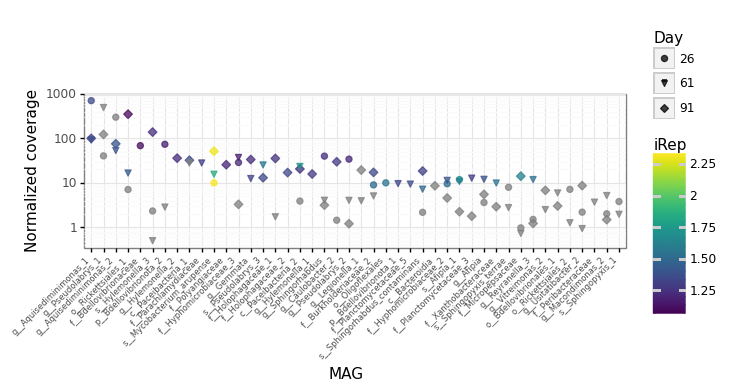

<ggplot: (400483295)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 2 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/awtp2/metagenomics/figures/abund_irep_MF.svg


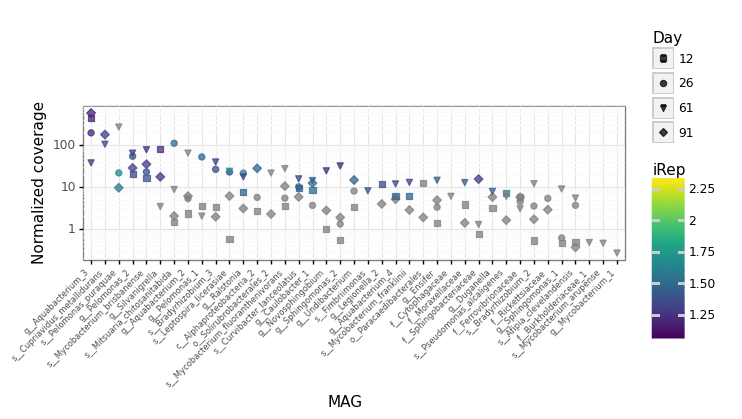

<ggplot: (401751628)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 2 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/awtp2/metagenomics/figures/abund_irep_RO.svg


In [947]:
plt1 = (ggplot(rank_ab_MF_df, aes(x='MAG_name', y='normalized_cov', color='iRep', shape='day'))+
    geom_point(alpha=0.75, size=2)+
    scale_y_log10()+
    scale_shape_manual(values=['o', 'v', 'D'])+
    scale_color_continuous(limits=[1.1,2.3])+
    ylab('Normalized coverage')+
    xlab('MAG')+
    labs(shape='Day')+
    theme_bw()+
    theme(figure_size=(7,2), axis_text_x=element_text(angle=45, hjust=1, size=6)))

display(plt1)
ggsave(plt1, '/Users/rosekantor/data/awtp2/metagenomics/figures/abund_irep_MF.svg')

plt2 = (ggplot(rank_ab_RO_df, aes(x='MAG_name', y='normalized_cov', color='iRep', shape='day'))+
    geom_point(alpha=0.75, size=2)+
    scale_y_log10()+
    scale_shape_manual(values=['s', 'o', 'v', 'D'])+
    scale_color_continuous(limits=[1.1,2.3])+
    ylab('Normalized coverage')+
    xlab('MAG')+
    labs(shape='Day')+
    theme_bw()+
    theme(figure_size=(7,2), axis_text_x=element_text(angle=45, hjust=1, size=6)))

display(plt2)
ggsave(plt2, '/Users/rosekantor/data/awtp2/metagenomics/figures/abund_irep_RO.svg')

In [927]:
rank_ab_ROBF_df.iRep.min() # max=1.78 min=1.25

1.246599375280277

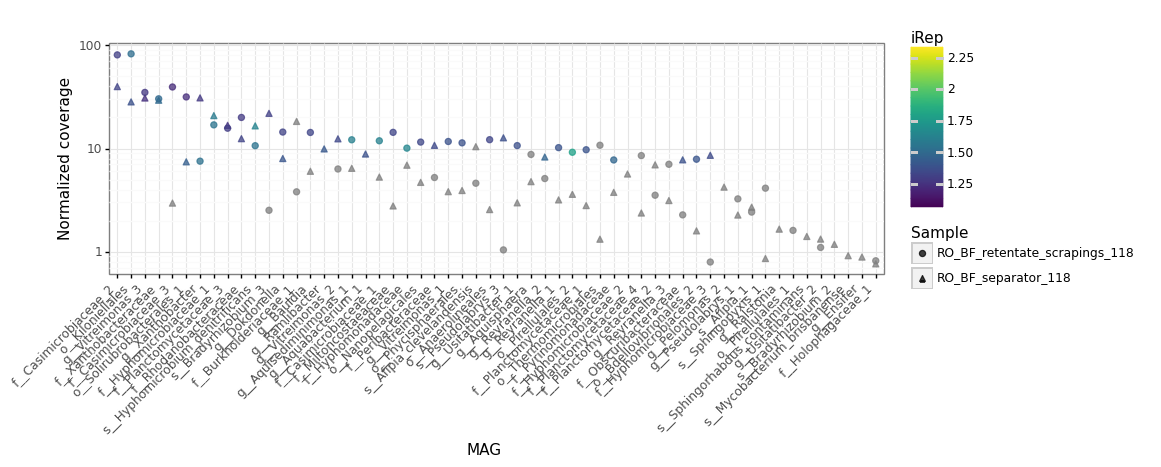

<ggplot: (393871981)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 3 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/awtp2/metagenomics/figures/abund_irep_ROBF.png


In [932]:
plt1 = (ggplot(rank_ab_ROBF_df, aes(x='MAG_name', y='normalized_cov', color='iRep', shape='sample_id'))+
    geom_point(alpha=0.75, size=2)+
    scale_y_log10()+
    scale_color_continuous(limits=[1.1,2.3])+
    ylab('Normalized coverage')+
    xlab('MAG')+
    labs(shape='Sample')+
    theme_bw()+
    theme(figure_size=(10,3), axis_text_x=element_text(angle=45, hjust=1)))

display(plt1)
ggsave(plt1, '/Users/rosekantor/data/awtp2/metagenomics/figures/abund_irep_ROBF.png')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_ydensity : Removed 135 rows containing non-finite values.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 135 rows containing non-finite values.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site

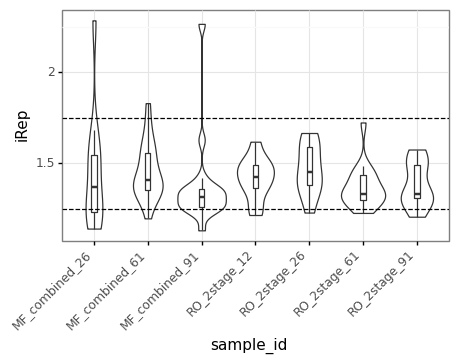

<ggplot: (391189092)>

In [476]:
plt = (ggplot(pd.concat([rank_ab_RO_df, rank_ab_MF_df]), aes(x='sample_id', y='iRep'))+
 geom_violin()+
 geom_boxplot(width=0.1, outlier_shape='')+
 #geom_jitter(aes(color='phylum', shape='phylum'), width=.2)+ # if merged with mag_stats_df first
 geom_hline(yintercept=1.75, linetype='dashed')+
 geom_hline(yintercept=1.25, linetype='dashed')+
 theme_bw()+
 theme(figure_size=(5,3), axis_text_x=element_text(angle=45, hjust=1)))

display(plt)
#ggsave(plt, '/Users/rosekantor/data/awtp2/metagenomics/figures/irep_violin_plot.png')

## MAG heatmap

In [685]:
# drop if NA in membrane samples after dropping RO-BF samples
rank_ab_df = rank_ab_df[~rank_ab_df.sample_id.str.contains('RO_BF')].copy()
rank_ab_wide_df = rank_ab_df.pivot(index='MAG_name', columns='sample_id', values='normalized_cov')

In [686]:
# drop MAGs whose abundance sums to 0 in the membrane samples
mem_samples = ['MF_combined_26', 'MF_combined_61', 'MF_combined_91', 
               'RO_2stage_12', 'RO_2stage_26', 'RO_2stage_61', 'RO_2stage_91']

rank_ab_wide_df = rank_ab_wide_df[rank_ab_wide_df[mem_samples].sum(axis=1)>0]

rank_ab_trimmed_df = rank_ab_wide_df.reset_index().melt(id_vars='MAG_name', 
                                                         value_name='normalized_cov', 
                                                         var_name='sample_id')

In [687]:
# export to make heatmap
rank_ab_wide_df.to_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_FiltNormCov_for_plotting_noROBF.tsv', sep='\t')

In [511]:
# # order sample_id for plotting
# sample_order = ['WW_3ary_12','WW_3ary_26','WW_3ary_61','WW_3ary_91',
#                 'BAC_12','BAC_26','BAC_61','BAC_91',
#                 'MF_combined_26','MF_combined_61','MF_combined_91',
#                 'RO_BF_retentate_scrapings_118', 'RO_BF_separator_118',
#                 'RO_2stage_12','RO_2stage_26','RO_2stage_61','RO_2stage_91']

# rank_ab_trimmed_df.sample_id = pd.Categorical(rank_ab_trimmed_df.sample_id, ordered=True, categories=sample_order)

In [572]:
# (ggplot(rank_ab_trimmed_df, aes(x='sample_id', y='MAG_name', fill='normalized_cov'))+
#  geom_tile(color='black')+
#  scale_fill_continuous(cmap_name="viridis", trans='log10')+
#  theme_classic()+
#  theme(figure_size=(4,15), 
#        axis_text_x=element_text(angle=45, hjust=1),
#        axis_text_y=element_text(size=7))
# )

# MAG metabolisms

## Identify which bins were at significantly higher abundance in MF vs RO samples

In [18]:
# most bins are only present in MF or RO but not in both
# make lists of MF-only bins and RO-only bins
# fill na with zero before calculating kruskal wallis

In [19]:
# cov_MF_RO_df = anvio_cov_df[anvio_cov_df.Location.isin(['MF_combined', 'RO_2stage'])].copy()
# cov_MF_RO_df = cov_MF_RO_df[['bins', 'Location', 'normalized_cov']]
# cov_MF_RO_df.normalized_cov = cov_MF_RO_df.normalized_cov.fillna(0)

# enriched_df = []

# for bin, df in cov_MF_RO_df.groupby(['bins']):
#     mf = df[df.Location=='MF_combined'].normalized_cov.values
#     ro = df[df.Location=='RO_2stage'].normalized_cov.values
    
#     enriched_in = None
    
#     if np.mean(mf) > np.mean(ro):
#         enriched_in = 'MF_combined'
        
#     elif np.mean(mf) < np.mean(ro):
#         enriched_in = 'RO_2stage'
    
#     U1, p = stats.mannwhitneyu(mf, ro)
    
    
#     enriched_df.append([bin, enriched_in, p, np.mean(mf), np.mean(ro)])

# enriched_df = pd.DataFrame.from_records(enriched_df, columns=['bins', 'enriched_in', 'p', 'mean_cov_mf', 'mean_cov_ro'])

In [20]:
# # checking that this makes sense
# #enriched_df.sort_values(by='p')
# display(enriched_df.shape)
# display(enriched_df[(enriched_df.mean_cov_mf>0) | (enriched_df.mean_cov_ro>0)].shape)
# display(enriched_df[(enriched_df.p < 0.05)].shape)

(143, 5)

(89, 5)

(35, 5)

Conclusion: maybe we should include all bins that were 0 in one group (MF or RO), rather than only bins with p<0.05. Especially given that there are only 3 samples of MF and 4 samples of RO, which makes it hard to get a significant p-value.

In [21]:
# # export to anvi_compute_metabolic_enrichment
# groups_for_anvio = enriched_df[(enriched_df.p < 0.05)][['bins', 'enriched_in']]
# # groups_for_anvio.to_csv('~/data/awtp2/metagenomics/dRep_membranes/groups_enriched.txt', sep='\t', index=False)

## metabolism plot by pathway

In [860]:
# load metabolism table produced by anvio
metabolism_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/kegg-metabolism_modules.txt', sep='\t')

## filter to keep only complete pathways
metabolism_df = metabolism_df[metabolism_df.pathwise_module_is_complete == True]
## filter to exclude modules with no unique enzymes
# metabolism_df = metabolism_df[~metabolism_df.proportion_unique_enzymes_present.isna()] 

In [861]:
# examining degradation of biomass building blocks since these may be the only nutrient source:

# module_category.isin(['Amino acid metabolism', 'Lipid metabolism', 'Nucleotide metabolism']) #'Carbohydrate metabolism'
metabolism_df[(metabolism_df.module_category == 'Amino acid metabolism') & 
              (metabolism_df.module_name.str.contains('degradation'))].module_name.unique()

metabolism_df[(metabolism_df.module_category == 'Nucleotide metabolism') & 
              (metabolism_df.module_name.str.contains('degradation'))].module_name.unique()

array(['Adenine ribonucleotide degradation, AMP => Urate',
       'Guanine ribonucleotide degradation, GMP => Urate',
       'Purine degradation, xanthine => urea',
       'Pyrimidine degradation, uracil => 3-hydroxypropanoate',
       'Pyrimidine degradation, uracil => beta-alanine, thymine => 3-aminoisobutanoate'],
      dtype=object)

In [862]:
# pathways to report in table
modules_of_interest = [
#                         'Nitrogen fixation, nitrogen => ammonia',
#                        'Reductive pentose phosphate cycle (Calvin cycle)',
#                        'Formaldehyde assimilation, serine pathway', 
#                        'Formaldehyde assimilation, xylulose monophosphate pathway'
#                        'Formaldehyde assimilation, ribulose monophosphate pathway'
                       'Methionine degradation',
                       'Histidine degradation, histidine => N-formiminoglutamate => glutamate',
                       'Tyrosine degradation, tyrosine => homogentisate',
                       'Leucine degradation, leucine => acetoacetate + acetyl-CoA',
                       'Lysine degradation, bacteria, L-lysine => glutarate => succinate/acetyl-CoA',
                       'Adenine ribonucleotide degradation, AMP => Urate',
                       'Guanine ribonucleotide degradation, GMP => Urate',
                       'Purine degradation, xanthine => urea',
                       'Pyrimidine degradation, uracil => 3-hydroxypropanoate',
                       'Pyrimidine degradation, uracil => beta-alanine, thymine => 3-aminoisobutanoate'
                      ]

# renaming modules to shorter names
module_dict = {'Nitrogen fixation, nitrogen => ammonia':'N2_fix',
               'Reductive pentose phosphate cycle (Calvin cycle)':'CO2_fix_Calvin',
               'Formaldehyde assimilation, serine pathway':'Formaldehyde_Ser',
               'Formaldehyde assimilation, xylulose monophosphate pathway':'Formaldehyde_XMP',
               'Formaldehyde assimilation, ribulose monophosphate pathway':'Formaldehyde_RMP',
                 'Methionine degradation':'Methionine degradation',
                 'Histidine degradation, histidine => N-formiminoglutamate => glutamate':'Histidine degradation',
                 'Tyrosine degradation, tyrosine => homogentisate':'Tyrosine degradation',
                 'Leucine degradation, leucine => acetoacetate + acetyl-CoA':'Leucine degradation',
                 'Lysine degradation, bacteria, L-lysine => glutarate => succinate/acetyl-CoA':'Lysine degradation',
                 'Adenine ribonucleotide degradation, AMP => Urate':'AMP degradation',
                 'Guanine ribonucleotide degradation, GMP => Urate':'GMP degradation',
                 'Purine degradation, xanthine => urea':'xanthine degradation',
                 'Pyrimidine degradation, uracil => 3-hydroxypropanoate':'uracil to 3HP',
                 'Pyrimidine degradation, uracil => beta-alanine, thymine => 3-aminoisobutanoate':'uracil to thymine'
              }

filt_metabolism_df = metabolism_df[metabolism_df.module_name.isin(modules_of_interest)].copy()
filt_metabolism_df = filt_metabolism_df[['bin_name', 'module_name', 'pathwise_module_completeness']].copy()

# pivot wide for SI table
wide_filt_metabolism_df = filt_metabolism_df.pivot(index='bin_name', columns='module_name', values='pathwise_module_completeness').reset_index()
wide_filt_metabolism_df = wide_filt_metabolism_df.rename(columns=module_dict)

In [863]:
# merge with sensible names
wide_filt_metabolism_df = pd.merge(final_mag_df_wide[['MAG_name', 'bins']], wide_filt_metabolism_df, 
                                   left_on='bins', right_on='bin_name', 
         how='outer')

wide_filt_metabolism_df = wide_filt_metabolism_df.drop(columns=['bins','bin_name'])

filt_metabolism_df = wide_filt_metabolism_df.melt(id_vars='MAG_name', 
                                                  var_name='module_name', 
                                                  value_name='pathwise_module_completeness')


# module_order = ['serine_pathway', 'N2_fixation', 'Methionine degradation',
#                 'Histidine degradation', 'Tyrosine degradation', 'Leucine degradation', 'Lysine degradation', 
#                 'AMP degradation', 'GMP degradation', 'xanthine degradation', 'uracil to 3HP', 'uracil to thymine']

# filt_metabolism_df.module_name = pd.Categorical(filt_metabolism_df.module_name, ordered=True, categories=module_order)
filt_metabolism_df.MAG_name = pd.Categorical(filt_metabolism_df.MAG_name, ordered=True, 
                                                  categories=filt_metabolism_df.MAG_name.unique())

filt_metabolism_df

,MAG_name,module_name,pathwise_module_completeness
0,o__Oligoflexales,AMP degradation,0.875
1,o__Rickettsiales_2,AMP degradation,0.750
2,f__Bdellovibrionaceae,AMP degradation,NaN
3,p__Bdellovibrionota_2,AMP degradation,1.000
4,s__Sphingopyxis_terrae,AMP degradation,NaN
...,...,...,...
1425,g__Undibacterium,Tyrosine degradation,1.000
1426,s__Mycobacterium_fluoranthenivorans,Tyrosine degradation,NaN
1427,s__Cupriavidus_metallidurans,Tyrosine degradation,0.800
1428,f__Sphingobacteriaceae,Tyrosine degradation,NaN


In [864]:
filt_metabolism_df.loc[filt_metabolism_df.pathwise_module_completeness.isna(), 'pathwise_module_completeness'] = 0
filt_metabolism_df.loc[filt_metabolism_df.pathwise_module_completeness<0.85, 'pathwise_module_completeness'] = 0
#filt_metabolism_df.loc[filt_metabolism_df.pathwise_module_completeness>=0.85, 'pathwise_module_completeness'] = 1

In [865]:
final_mags = rank_ab_trimmed_df.MAG_name.unique().tolist()
filt_metabolism_df = filt_metabolism_df[filt_metabolism_df.MAG_name.isin(final_mags)]

# pivot wide for heatmap plotting
filt_metabolism_wide_df = filt_metabolism_df.pivot(index='MAG_name', 
                                                   columns='module_name', 
                                                   values='pathwise_module_completeness')

# save for plotting in R
# filt_metabolism_wide_df.to_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_metabolism_for_plotting_no_ROBF.tsv', sep='\t')

## metabolism plot by enzyme

In [866]:
# enzymes of interest
# rubisco = ['K01602', 'K01601']
# formate_dehydrogenase = ['K00148'] # formaldehyde to formate
# formaldehyde_dismutase = ['K17068', 'K17067'] # formaldehyde to methanol
# Nif_genes = ['K02588', 'K02586', 'K02591']

enzymes_of_interest = ['K01602', 'K01601', 'K00148', 'K17068', 'K17067', 'K02588', 'K02586', 'K02591']
enzyme_dict = {'K01602':'RuBisCo_rbcS', 
               'K01601':'RuBisCo_rbcL', 
               'K00148':'formate_dehydrogenase_fdhA', 
               'K17068':'formaldehyde_dismutase_fdm', 
               'K17067':'formaldehyde_dismutase_mdo',
               'K02588':'N2_fixation_nifH', 
               'K02586':'N2_fixation_nifD', 
               'K02591':'N2_fixation_nifK'}

In [876]:
# load metabolism table produced by anvio
metabolism_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/kegg-metabolism_modules.txt', sep='\t')
# reassign nan to empty string before doing a string-based search
metabolism_df.loc[metabolism_df.enzyme_hits_in_module.isna(), 'enzyme_hits_in_module'] = ''

In [880]:
metabolism_df[(metabolism_df.module_name.str.contains('photosynthesis')) &
              (metabolism_df.pathwise_module_is_complete == True)]

,module,bin_name,module_name,module_class,module_category,module_subcategory,module_definition,stepwise_module_completeness,stepwise_module_is_complete,pathwise_module_completeness,pathwise_module_is_complete,proportion_unique_enzymes_present,enzymes_unique_to_module,unique_enzymes_hit_counts,enzyme_hits_in_module,gene_caller_ids_in_module,warnings
1210,M00612,AWTP2_SAMPLE_RO2_BIOFILM_RET_1_metabat2_1625,Anoxygenic photosynthesis in purple bacteria,Signature modules,Module set,Metabolic capacity,M00597 M00165,1.0,True,0.954545,True,NaN,No enzymes unique to module,NaN,"K00134,K00615,K00615,K00855,K00927,K01601,K016...","410307,396172,437397,437396,410309,437391,4373...",K00927 is present in multiple modules: M00001/...
4815,M00612,AWTP2_SAMPLE_MFCOMB_BULK_1_vamb_2600,Anoxygenic photosynthesis in purple bacteria,Signature modules,Module set,Metabolic capacity,M00597 M00165,1.0,True,0.909091,True,NaN,No enzymes unique to module,NaN,"K00134,K00615,K00927,K01623,K01807,K08928,K089...","337218,392699,392691,554906,406634,487165,4871...",K00927 is present in multiple modules: M00001/...
4816,M00613,AWTP2_SAMPLE_MFCOMB_BULK_1_vamb_2600,Anoxygenic photosynthesis in green nonsulfur b...,Signature modules,Module set,Metabolic capacity,M00597 M00376,0.5,False,0.769231,True,NaN,No enzymes unique to module,NaN,"K00239,K00240,K00240,K00241,K00242,K00244,K002...","502421,337311,502085,502423,502422,502082,5020...",K05606 is present in multiple modules: M00373/...
7393,M00612,AWTP2_SAMPLE_RO2_BULK_5_maxbin2_35_sub_1,Anoxygenic photosynthesis in purple bacteria,Signature modules,Module set,Metabolic capacity,M00597 M00165,1.0,True,0.954545,True,NaN,No enzymes unique to module,NaN,"K00134,K00615,K00615,K00615,K00855,K00927,K009...","294638,106381,294639,459037,106382,552932,2946...",K00927 is present in multiple modules: M00001/...
8248,M00612,AWTP2_SAMPLE_MFCOMB_BULK_2_concoct_51,Anoxygenic photosynthesis in purple bacteria,Signature modules,Module set,Metabolic capacity,M00597 M00165,1.0,True,0.909091,True,NaN,No enzymes unique to module,NaN,"K00134,K00615,K00615,K00927,K01624,K01807,K089...","392848,256352,622298,622297,296940,215373,2967...",K00927 is present in multiple modules: M00001/...
8249,M00613,AWTP2_SAMPLE_MFCOMB_BULK_2_concoct_51,Anoxygenic photosynthesis in green nonsulfur b...,Signature modules,Module set,Metabolic capacity,M00597 M00376,0.5,False,0.769231,True,NaN,No enzymes unique to module,NaN,"K00239,K00240,K00240,K00241,K00242,K00244,K002...","474369,53457,529090,474371,474370,529093,52909...",K05606 is present in multiple modules: M00373/...
10568,M00612,AWTP2_SAMPLE_RO2_BULK_5_maxbin2_39,Anoxygenic photosynthesis in purple bacteria,Signature modules,Module set,Metabolic capacity,M00597 M00165,1.0,True,0.954545,True,NaN,No enzymes unique to module,NaN,"K00134,K00134,K00615,K00615,K00855,K00927,K009...","106475,606607,106474,606605,106472,106476,3909...",K00927 is present in multiple modules: M00001/...
11242,M00612,AWTP2_SAMPLE_RO2_BIOFILM_SEP_1_concoct_57,Anoxygenic photosynthesis in purple bacteria,Signature modules,Module set,Metabolic capacity,M00597 M00165,0.5,False,0.818182,True,NaN,No enzymes unique to module,NaN,"K00134,K00615,K00615,K00615,K00927,K01624,K018...","496052,496051,155360,155359,455068,455072,3305...",K00927 is present in multiple modules: M00001/...
12698,M00612,AWTP2_SAMPLE_RO2_BIOFILM_RET_2_concoct_72_sub,Anoxygenic photosynthesis in purple bacteria,Signature modules,Module set,Metabolic capacity,M00597 M00165,1.0,True,0.954545,True,NaN,No enzymes unique to module,NaN,"K00134,K00615,K00615,K00615,K00615,K00855,K009...","534493,356392,627640,627639,127731,179700,3979...",K00927 is present in multiple modules: M00001/...
12699,M00613,AWTP2_SAMPLE_RO2_BIOFILM_RET_2_concoct_72_sub,Anoxygenic photosynthesis in green nonsulfur b...,Signature modules,Module set,Metabolic capacity,M00597 M00376,0.5,False,0.794872,True,NaN,No enzymes unique to module,NaN,"K00240,K00240,K00241,K00242,K00244,K00246,K002...","45

In [868]:
enzyme_based_df = []
for row in metabolism_df.itertuples():
    bin_name = row.bin_name
    bin_enzymes = row.enzyme_hits_in_module.split(',')
    for enzyme in enzymes_of_interest:
        if enzyme in bin_enzymes:
            enzyme_based_df.append([bin_name, enzyme, 1])

enzyme_based_df = pd.DataFrame.from_records(enzyme_based_df, columns=['bin_name', 'enzyme', 'presence'])
enzyme_based_df = enzyme_based_df.drop_duplicates()

In [869]:
# pivot wide for SI table
wide_filt_enzymes_df = enzyme_based_df.pivot(index='bin_name', columns='enzyme', values='presence').reset_index()
wide_filt_enzymes_df = wide_filt_enzymes_df.rename(columns=enzyme_dict)

In [870]:
wide_filt_enzymes_df = pd.merge(final_mag_df_wide[['MAG_name', 'bins']], wide_filt_enzymes_df, 
                                   left_on='bins', right_on='bin_name', how='left')
wide_filt_enzymes_df = wide_filt_enzymes_df.drop(columns=['bins', 'bin_name'])
wide_filt_enzymes_df = wide_filt_enzymes_df.fillna(0)
wide_filt_enzymes_df.head()

,MAG_name,RuBisCo_rbcL,RuBisCo_rbcS,N2_fixation_nifD,N2_fixation_nifH,N2_fixation_nifK
0,o__Oligoflexales,0.0,0.0,0.0,0.0,0.0
1,o__Rickettsiales_2,0.0,0.0,0.0,0.0,0.0
2,f__Bdellovibrionaceae,0.0,0.0,0.0,0.0,0.0
3,p__Bdellovibrionota_2,0.0,0.0,0.0,0.0,0.0
4,s__Sphingopyxis_terrae,0.0,0.0,0.0,0.0,0.0


In [871]:
final_mags = rank_ab_trimmed_df.MAG_name.unique().tolist()
wide_filt_enzymes_df = wide_filt_enzymes_df[wide_filt_enzymes_df.MAG_name.isin(final_mags)]

In [872]:
# merge enzymes and modules into one table for plotting
metab_enz_df = wide_filt_enzymes_df.merge(filt_metabolism_wide_df, on='MAG_name')

In [873]:
metab_enz_df = metab_enz_df.replace(0, np.nan)

In [874]:
metab_enz_df.head()

,MAG_name,RuBisCo_rbcL,RuBisCo_rbcS,N2_fixation_nifD,N2_fixation_nifH,N2_fixation_nifK,AMP degradation,GMP degradation,Histidine degradation,Leucine degradation,Lysine degradation,Methionine degradation,Tyrosine degradation,uracil to 3HP,uracil to thymine,xanthine degradation
0,o__Oligoflexales,NaN,NaN,NaN,NaN,NaN,0.875,0.875,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,o__Rickettsiales_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f__Bdellovibrionaceae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,p__Bdellovibrionota_2,NaN,NaN,NaN,NaN,NaN,1.000,NaN,1.0,0.861111,NaN,NaN,NaN,NaN,1.0,NaN
4,s__Sphingopyxis_terrae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [875]:
# save for plotting in R
#wide_filt_metabolism_df.to_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_enzymes_for_plotting_no_ROBF.tsv', sep='\t', index=False)

metab_enz_df.to_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_metabEnzymes_for_plotting_no_ROBF.tsv', sep='\t', index=False)

# Visualize virus mapping data

In [288]:
# collect accessions for all viruses downloaded as custom ref database and make a table
ref_db = []
for file in glob('/Users/rosekantor/data/awtp2/metagenomics/virus_refs/*_complete_genomes.fasta'):
    tax = os.path.basename(file)
    tax = re.split("_complete_genomes", tax)[0]
    for record in SeqIO.parse(file, "fasta"):
        ref_db.append([record.id, tax])
        
ref_db = pd.DataFrame.from_records(ref_db, columns=['accession', 'tax'])

ref_db.head()

,accession,tax
0,NC_001699.1,jc_polyomavirus
1,OR661738.1,jc_polyomavirus
2,OQ230875.1,jc_polyomavirus
3,OQ230876.1,jc_polyomavirus
4,OQ230877.1,jc_polyomavirus


In [244]:
# combine all readcount data from all samples
hits_df = []
for file in glob('/Users/rosekantor/data/awtp2/metagenomics/virus_mappings/*tsv'):
    samp = os.path.basename(file)
    samp = re.split("_virus_reads_mapped.tsv", samp)[0]
    df = pd.read_csv(file, sep='\t', names=['accession', 'len', 'mapped', 'unmapped'])
    df['sample_name'] = samp
    hits_df.append(df)
hits_df = pd.concat(hits_df)

# merge with reference taxonomy info df
hits_df = hits_df.merge(ref_db, on='accession', how='outer')

# drop zeros (rows with nothing mapped)
hits_df = hits_df[hits_df.mapped > 0]

# group and summarize hits by taxa within each sample
hits_grouped = hits_df.groupby(['sample_name', 'tax']).aggregate(total_mapped=('mapped','sum'), length=('len','max')).reset_index()
hits_grouped.sample_name = hits_grouped.sample_name.str.replace('-', '_') # replace to match names in summary_stats_df

# merge in the sample_id
summary_stats_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/tables/summary_stats_table_060623.csv')
summary_stats_df = summary_stats_df[~summary_stats_df.total_seq_Gb.isna()] # drop samples that had 16S only
hits_grouped = pd.merge(hits_grouped, summary_stats_df, on='sample_name', how='left')
hits_grouped = hits_grouped[['sample_id', 'tax', 'total_mapped', 'length', 'total_seq_Gb']]
hits_grouped['perc_rel_abund'] = hits_grouped.total_mapped * 150 * 100 / (hits_grouped.total_seq_Gb * 1e9)

In [245]:
# order by sample_id for plotting

# order samples for plotting
sample_order = ['WW_3ary_12','WW_3ary_26','WW_3ary_61','WW_3ary_91',
                'BAC_12','BAC_26','BAC_61','BAC_91',
                'MF_combined_26','MF_combined_61','MF_combined_91',
                'RO_BF_retentate_scrapings_118', 'RO_BF_separator_118',
                'RO_BF_retentate_scrapings_328','RO_BF_separator_328',
                'RO_2stage_12','RO_2stage_26','RO_2stage_61','RO_2stage_91']

hits_grouped.sample_id = pd.Categorical(hits_grouped.sample_id, ordered = True, categories = sample_order)

tax_order = ['betapolyomavirus_hominis', 'jc_polyomavirus', 
             'human_mastadenovirus_A', 'human_mastadenovirus_B', 'human_mastadenovirus_C', 
             'human_mastadenovirus_D', 'human_mastadenovirus_E', 'human_mastadenovirus_F', 
             'human_mastadenovirus_G']
hits_grouped.tax = pd.Categorical(hits_grouped.tax, ordered=True, categories=tax_order[::-1])

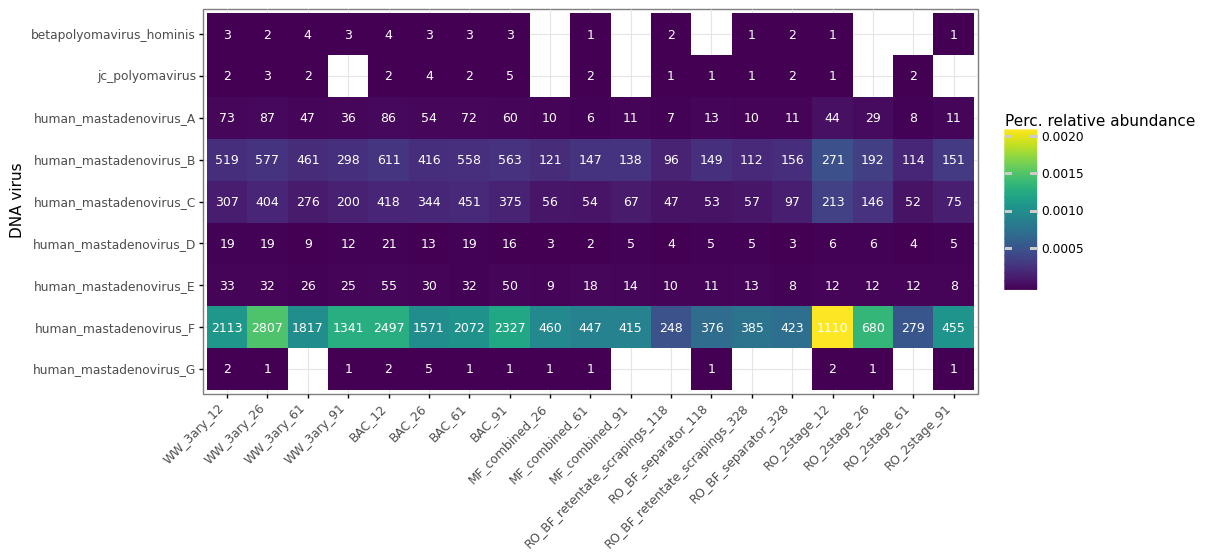

<ggplot: (379689099)>

In [259]:
(ggplot(hits_grouped, aes(x='sample_id', y='tax', fill='perc_rel_abund', label='total_mapped'))+
    geom_tile()+
    geom_text(color='white', size='9')+
    labs(fill='Perc. relative abundance')+
    scale_fill_continuous()+
    ylab('DNA virus')+
    xlab('')+
    theme_bw()+
    theme(
        axis_text_x=element_text(angle=45, hjust=1),
        figure_size=(10,5))
)

In [282]:
# combine all readcount data from all samples
hits_df = []
for file in glob('/Users/rosekantor/data/awtp2/metagenomics/virus_mappings/*cov.txt'):
    samp = os.path.basename(file)
    samp = re.split("_virus_reads_mapped.tsv", samp)[0]
    df = pd.read_csv(file, sep='\t')
    df['sample_name'] = samp
    hits_df.append(df)
hits_df = pd.concat(hits_df)

In [293]:
hits_df = hits_df.rename(columns={'#rname':'accession'})
hits_df[hits_df.numreads!=0].merge(ref_db, on='accession')


,accession,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,sample_name,tax
0,ON561778.1,1,34175,2,221,0.646672,0.008778,36.4,1,AWTP2_SAMPLE_INF_BULK_4-vs-polyomavirus_adenov...,human_mastadenovirus_F
1,OP255975.1,1,34184,2,240,0.702083,0.008776,37.0,1,AWTP2_SAMPLE_INF_BULK_4-vs-polyomavirus_adenov...,human_mastadenovirus_F
2,AB728839.1,1,34179,2,300,0.877732,0.008777,36.2,1,AWTP2_SAMPLE_INF_BULK_4-vs-polyomavirus_adenov...,human_mastadenovirus_F
3,ON815881.1,1,34200,2,300,0.877193,0.008772,34.5,1,AWTP2_SAMPLE_INF_BULK_3-vs-polyomavirus_adenov...,human_mastadenovirus_F
4,MT277585.1,1,36523,2,197,0.539386,0.007913,36.4,0,AWTP2_SAMPLE_RO2_BIOFILM-SEP_2-vs-polyomavirus...,human_mastadenovirus_C


## investigate mastadenovirus F hits in RO

In [272]:
# found the accession with max hits
hits_df[hits_df.mapped == hits_df.mapped.max()]
hits_df[hits_df.accession == 'OP174921.1'].sort_values('sample_name')

,accession,len,mapped,unmapped,sample_name,tax
39585,OP174921.1,34172,581,581,AWTP2_SAMPLE_BAC_BULK_2,human_mastadenovirus_F
39591,OP174921.1,34172,323,323,AWTP2_SAMPLE_BAC_BULK_3,human_mastadenovirus_F
39594,OP174921.1,34172,452,452,AWTP2_SAMPLE_BAC_BULK_4,human_mastadenovirus_F
39583,OP174921.1,34172,519,519,AWTP2_SAMPLE_BAC_BULK_5,human_mastadenovirus_F
39582,OP174921.1,34172,476,477,AWTP2_SAMPLE_INF_BULK_2,human_mastadenovirus_F
39593,OP174921.1,34172,648,648,AWTP2_SAMPLE_INF_BULK_3,human_mastadenovirus_F
39590,OP174921.1,34172,383,386,AWTP2_SAMPLE_INF_BULK_4,human_mastadenovirus_F
39584,OP174921.1,34172,312,313,AWTP2_SAMPLE_INF_BULK_5,human_mastadenovirus_F
39588,OP174921.1,34172,101,101,AWTP2_SAMPLE_MFCOMB_BULK_1,human_mastadenovirus_F
39581,OP174921.1,34172,128,128,AWTP2_SAMPLE_MFCOMB_BULK_2,human_mastadenovirus_F


In [281]:
with open('/Users/rosekantor/data/awtp2/metagenomics/virus_refs/mastadenovirus_F_OP174921_1.fasta', 'w') as f:
    for record in SeqIO.parse('/Users/rosekantor/data/awtp2/metagenomics/virus_refs/human_mastadenovirus_F_complete_genomes.fasta', "fasta"):
        if record.id == 'OP174921.1':
            f.write(f'>{record.id}\n{record.seq}')
f.close()

NOTE: Most of these were ultra short reads. After excluding reads < 75 bp, concluded based on visualization of read mapping that all reads mapped to the same region, so they probably don't represent "true" detection of these viruses.